# Impact Assessment of Data Poisoning Attacks on Collaborative Intrusion Detection Systems using Federated Learning

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from toolbox import init, newfig

init(style="beamer.mplstyle")

SAVEDIR = "/Users/leo/Workspace/phdcybersec/slides_ares_2024/src/figures/"

## RQ1: Is the behavior predictable?

A preliminary question to solve is how predictable is the behavior of the attack propagation, given a scenario and a distribution; *ie.*, how scattered are the results at a given point in time, for different seeds.

### Test methodology

Test a set of different seeds on: 5/5, continuous-100. Plot:
1. stats
   - mean
   - standard deviation (envelope mean-std, mean+std)
   - min/max
2. differential analysis 
   - |mean-mean^-1| over time
   - |std-std^-1| over time

**Seeds list**: 1138, 421, 1313, 5555, 6567, 327, 2187, 1977, 501, 3263827

In [3]:
from eiffel.analysis.metrics import choices, display_choices

display_choices(choices("longruns/results/"))

Key,Values
datasets,nfv2_sampled_cicids
distribution,5-5
epochs,"300_10x30, 300_1x300, 300_4x75"
scenario,continuous-100
target,untargeted
batch_size,"32, 512"
partitioner,iid
seed,"5555, 1138, 501, 2187, 1313, 327, 1977, 421, 3263827, 6567"


There is a surprisingly high amount of dispersion in the results between runs. 
With a simple example (batch size 512, 1 local epoch per round, 50% of attackers), the accuracy varies from ~0.1 to ~0.8 for the **same** round (after 10 rounds).
Standard deviation is around 0.2, which is a lot considering the scale (between 0 and 1).

Longer runs (300 local epochs, batch size 512) show a stabilization in the results, but the dispersion is still high.
Notably, after round 10, there are no more evolution (on average) in each run, so each run is stable after 10 rounds.

It could be interpreted as a consequence of the complexity of the learning tasks, which becomes harder as clients contain different labels for similar samples.
Therefore, the problem probably admit a high number of local minima, which are reached depending on the seed.

Finally, the accuracy difference never really reaches zero, so while the models do converge, they continue to vary slightly.

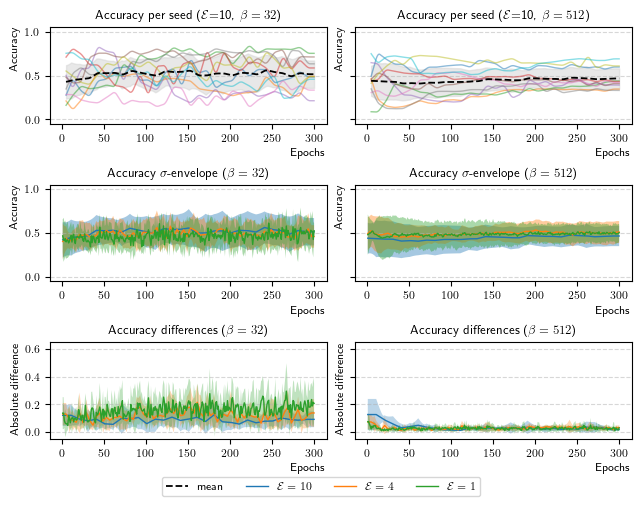

In [4]:
import functools
from functools import partial

import numpy as np
import pandas as pd
from eiffel.analysis.metrics import load_metric, search_results
from eiffel.analysis.plot import Plotable, scale
from matplotlib import pyplot as plt
from matplotlib.axes import Axes

load_fn = partial(
    load_metric, dotpath="global.accuracy", attr="distributed", with_malicious=False
)

search_fn = partial(
    search_results,
    "longruns/results/",
    scenario="continuous-100",
    target="untargeted",
    distribution="5-5",
    datasets=".*cicids",
)

fig = newfig(format=4 / 3)
axs = fig.subplots(3, 2, sharex=True, sharey="row")

# Axis 0: Accuracy per Seed
# -------------------------------------
for ax, batch_size in zip(axs[0, :], [32, 512]):
    ax: Axes
    epochs = 10
    ax.set_title(
        rf"Accuracy per seed ($\mathcal{'{E}'}$={epochs}, $\beta={batch_size}$)",
    )
    ax.set_ylabel("Accuracy", loc="top")

    accs = scale(
        [
            Plotable(m, load_fn(m))
            for m in search_fn(epochs=f"300_{epochs}x.*", batch_size=batch_size)
        ],
        300,
    )

    # stack the values
    data = np.array([p.values for p in accs])
    x = np.arange(1, len(data[0]) + 1)  # rounds are indexed from 1

    mean = pd.DataFrame(np.mean(data, axis=0), index=x)
    mean = mean.rolling(window=5).mean()[0]
    sigma = np.std(data, axis=0)
    low_sigma = mean - sigma
    high_sigma = mean + sigma
    _min = np.min(data, axis=0)
    _max = np.max(data, axis=0)

    # plot

    for acc in accs:
        ax.plot(pd.DataFrame(acc.values, index=x).rolling(window=5).mean(), alpha=0.5)

    ax.plot(
        mean,
        label="mean",
        linewidth=1.3,
        color="black",
        linestyle="--",
    )
    ax.fill_between(x, low_sigma, high_sigma, alpha=0.5, color="lightgrey")
    # ax.fill_between(x, _min, _max, alpha=0.3, color="lightgrey")

# Axis 1: Accuracy Distribution
# -------------------------------------
for ax, batch_size in zip(axs[1, :], [32, 512]):
    ax: Axes
    ax.set_title(rf"Accuracy $\sigma$-envelope ($\beta={batch_size}$)")
    ax.set_ylabel("Accuracy", loc="top")

    color_counter = 0
    for epochs in [10, 4, 1]:
        accs = scale(
            [
                Plotable(m, load_fn(m))
                for m in search_fn(epochs=rf"300_{epochs}x.*", batch_size=batch_size)
            ],
            300,
        )

        # stack the values
        data = np.array([p.values for p in accs])

        # Compute mean & standard deviation
        mean = np.mean(data, axis=0)
        sigma = np.std(data, axis=0)
        low_sigma = mean - sigma
        high_sigma = mean + sigma

        # plot
        x = np.arange(1, len(mean) + 1)  # rounds are indexed from 1

        ax.plot(
            x,
            mean,
            label=rf"$\mathcal{'{E}'}={epochs}$",
            linewidth=1,
            color=f"C{color_counter}",
        )
        ax.fill_between(x, low_sigma, high_sigma, alpha=0.4)
        color_counter += 1

# Axis 2: Difference in Accuracy
# -------------------------------------
for ax, batch_size in zip(axs[2, :], [32, 512]):
    ax: Axes
    ax.set_title(rf"Accuracy differences ($\beta={batch_size}$)")
    ax.set_ylabel("Absolute difference", loc="top")

    color_counter = 0
    for epochs in [10, 4, 1]:
        accs = [
            Plotable(m, load_fn(m))
            for m in search_fn(epochs=rf"300_{epochs}x.*", batch_size=batch_size)
        ]

        accs_diff = scale(
            [
                Plotable(
                    p.name,
                    [abs(p.values[1] - p.values[0])]
                    + [
                        abs(p.values[i] - p.values[i - 1])
                        for i in range(1, len(p.values))
                    ],
                )
                for p in accs
            ],
            300,
        )

        # stack the values
        data = np.array([p.values for p in accs_diff])

        # Compute mean & standard deviation
        mean = np.mean(data, axis=0)
        sigma = np.std(data, axis=0)
        low_sigma = mean - sigma
        high_sigma = mean + sigma

        # plot
        x = np.arange(1, len(mean) + 1)  # rounds are indexed from 1

        ax.plot(
            x,
            mean,
            label=rf"$\mathcal{'{E}'}={epochs}$",
            linewidth=1,
            color=f"C{color_counter}",
        )
        ax.fill_between(x, low_sigma, high_sigma, alpha=0.3)
        color_counter += 1

for (i, j), ax in np.ndenumerate(axs):
    ax.tick_params(labelbottom=True)
    ax.grid(axis="y", linestyle="--", alpha=0.5)
    ax.set_xlabel("Epochs", loc="right")

    if i == 2:
        ax.set_ylim(-0.05, 0.65)
    else:
        ax.set_ylim(-0.05, 1.05)

handles, labels = functools.reduce(
    lambda x, y: (x[0] + y[0], x[1] + y[1]),
    map(lambda ax: ax.get_legend_handles_labels(), [axs[0, 0], axs[2, 1]]),
)
lgd = fig.legend(
    handles, labels, loc="lower center", ncol=4, bbox_to_anchor=(0.5, -0.05)
)

# fig.savefig(
#     SAVEDIR + "predictability-all.pdf", bbox_extra_artists=(lgd,), bbox_inches="tight"
# )

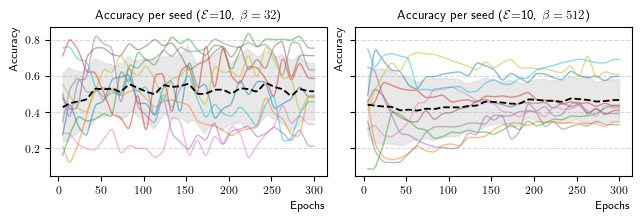

In [5]:
import functools
from functools import partial

import numpy as np
import pandas as pd
from eiffel.analysis.metrics import load_metric, search_results
from eiffel.analysis.plot import Plotable, scale
from matplotlib import pyplot as plt
from matplotlib.axes import Axes

load_fn = partial(
    load_metric, dotpath="global.accuracy", attr="distributed", with_malicious=False
)

search_fn = partial(
    search_results,
    "longruns/results/",
    scenario="continuous-100",
    target="untargeted",
    distribution="5-5",
    datasets=".*cicids",
)

fig = newfig(format=3 / 1)
axs = fig.subplots(1, 2, sharex=True, sharey="row")

# Axis 0: Accuracy per Seed
# -------------------------------------
for ax, batch_size in zip(axs, [32, 512]):
    ax: Axes
    epochs = 10
    ax.set_title(
        rf"Accuracy per seed ($\mathcal{'{E}'}$={epochs}, $\beta={batch_size}$)",
    )
    ax.set_ylabel("Accuracy", loc="top")

    accs = scale(
        [
            Plotable(m, load_fn(m))
            for m in search_fn(epochs=f"300_{epochs}x.*", batch_size=batch_size)
        ],
        300,
    )

    # stack the values
    data = np.array([p.values for p in accs])
    x = np.arange(1, len(data[0]) + 1)  # rounds are indexed from 1

    mean = pd.DataFrame(np.mean(data, axis=0), index=x)
    mean = mean.rolling(window=5).mean()[0]
    sigma = np.std(data, axis=0)
    low_sigma = mean - sigma
    high_sigma = mean + sigma
    _min = np.min(data, axis=0)
    _max = np.max(data, axis=0)

    # plot

    for acc in accs:
        ax.plot(pd.DataFrame(acc.values, index=x).rolling(window=5).mean(), alpha=0.5)

    ax.plot(
        mean,
        label="mean",
        linewidth=1.3,
        color="black",
        linestyle="--",
    )
    ax.fill_between(x, low_sigma, high_sigma, alpha=0.5, color="lightgrey")


for ax in axs:
    ax.tick_params(labelbottom=True)
    ax.grid(axis="y", linestyle="--", alpha=0.5)
    ax.set_xlabel("Epochs", loc="right")


fig.savefig(SAVEDIR + "predictability-all.pdf", bbox_inches="tight")

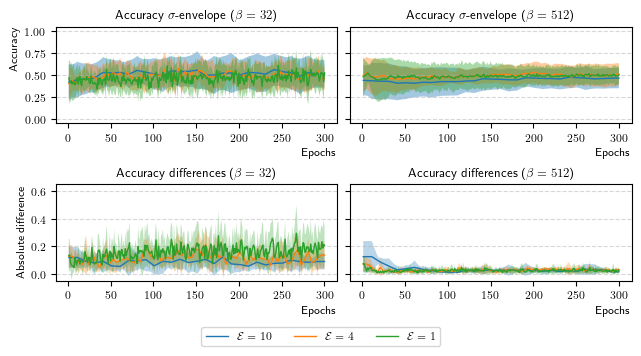

In [7]:
import functools
from functools import partial

import numpy as np
import pandas as pd
from eiffel.analysis.metrics import load_metric, search_results
from eiffel.analysis.plot import Plotable, scale
from matplotlib import pyplot as plt
from matplotlib.axes import Axes

load_fn = partial(
    load_metric, dotpath="global.accuracy", attr="distributed", with_malicious=False
)

search_fn = partial(
    search_results,
    "longruns/results/",
    scenario="continuous-100",
    target="untargeted",
    distribution="5-5",
    datasets=".*cicids",
)

fig = newfig(format=2 / 1)
axs = fig.subplots(2, 2, sharex=True, sharey="row")


# Axis 0: Accuracy Distribution
# -------------------------------------
for ax, batch_size in zip(axs[0, :], [32, 512]):
    ax: Axes
    ax.set_title(rf"Accuracy $\sigma$-envelope ($\beta={batch_size}$)")

    color_counter = 0
    for epochs in [10, 4, 1]:
        accs = scale(
            [
                Plotable(m, load_fn(m))
                for m in search_fn(epochs=rf"300_{epochs}x.*", batch_size=batch_size)
            ],
            300,
        )

        # stack the values
        data = np.array([p.values for p in accs])

        # Compute mean & standard deviation
        mean = np.mean(data, axis=0)
        sigma = np.std(data, axis=0)
        low_sigma = mean - sigma
        high_sigma = mean + sigma

        # plot
        x = np.arange(1, len(mean) + 1)  # rounds are indexed from 1

        ax.plot(
            x,
            mean,
            label=rf"$\mathcal{'{E}'}={epochs}$",
            linewidth=1,
            color=f"C{color_counter}",
        )
        ax.fill_between(x, low_sigma, high_sigma, alpha=0.4)
        color_counter += 1

# Axis 1: Difference in Accuracy
# -------------------------------------
for i, ax, batch_size in zip((0, 1), axs[1, :], [32, 512]):
    ax: Axes
    ax.set_title(rf"Accuracy differences ($\beta={batch_size}$)")

    color_counter = 0
    for epochs in [10, 4, 1]:
        accs = [
            Plotable(m, load_fn(m))
            for m in search_fn(epochs=rf"300_{epochs}x.*", batch_size=batch_size)
        ]

        accs_diff = scale(
            [
                Plotable(
                    p.name,
                    [abs(p.values[1] - p.values[0])]
                    + [
                        abs(p.values[i] - p.values[i - 1])
                        for i in range(1, len(p.values))
                    ],
                )
                for p in accs
            ],
            300,
        )

        # stack the values
        data = np.array([p.values for p in accs_diff])

        # Compute mean & standard deviation
        mean = np.mean(data, axis=0)
        sigma = np.std(data, axis=0)
        low_sigma = mean - sigma
        high_sigma = mean + sigma

        # plot
        x = np.arange(1, len(mean) + 1)  # rounds are indexed from 1

        ax.plot(
            x,
            mean,
            label=rf"$\mathcal{'{E}'}={epochs}$",
            linewidth=1,
            color=f"C{color_counter}",
        )
        ax.fill_between(x, low_sigma, high_sigma, alpha=0.3)
        color_counter += 1

for (i, j), ax in np.ndenumerate(axs):
    ax.tick_params(labelbottom=True)
    ax.grid(axis="y", linestyle="--", alpha=0.5)
    ax.set_xlabel("Epochs", loc="right")

    if i == 1:
        ax.set_ylim(-0.05, 0.65)
    else:
        ax.set_ylim(-0.05, 1.05)
        ax.set_yticks(np.arange(0, 1.1, 0.25))

axs[0, 0].set_ylabel("Accuracy", loc="top")
axs[1, 0].set_ylabel("Absolute difference", loc="top")

handles, labels = ax.get_legend_handles_labels()
lgd = fig.legend(
    handles,
    labels,
    loc="lower center",
    ncol=4,
    bbox_to_anchor=(0.5, -0.1),
    frameon=True,
)

fig.savefig(
    SAVEDIR + "predictability-envelopes.pdf",
    bbox_extra_artists=(lgd,),
    bbox_inches="tight",
)

With less local epochs or a smaller batch size, the dispersion is even higher, and the models appear to be less stable.
Notably, the accuracy difference grows over time for the second run (epochs=10, batch_size=32).
This is to factor in for subsequent analyses using this combination, as it can affect the observed results.

### Conclusions

- A 100% continuous attack perpetrated by 50% of the nodes produces **in average** a 50% detection rate.
- Over ten runs, the results are very sparse: the standard deviation is very high, and the min/max values are very far from the mean.

If the mean value does not change, and neither does the distribution of the results, then it pretty much acts like if the rounds where independent. 
So maybe the ML operations are consequent enough (even for one epoch) that it neglects the impact of the initial conditions on the output.

The results *tend* to confirm the expected hypotheses **in average**. However, it is difficult to predict the behavior of one specific attack.
The results of further analyses (RQ1-4) must be interpreted with this in mind.

**THEREFORE**: While the results of existing defense mechanisms are not to be discarded, such unpredictability might mean that some specific attacks might bypass them if they are not designed to be robust to such variations.

